In [1]:
# Parameters
MPV_CONCENTRATION_RATE_PERCENT = 100.0
MPV_INVERTER_APPARENT_POWER_WATT = 800
MPV_SOLAR_CELL_CAPACITY_WATT = 800
ID = 4
OUTPUT_NB_DIR = "/hkfs/home/haicore/iai/ii6824/Documents/PIDE/output/notebook/"  # Update this with your actual path

# PIDE
##### **P**hotovoltaic **I**ntegration **D**ynamics and **E**fficiency for Autonomous Control on Power Distribution Grids
## **Case study 1:  Sensitivity analysis of mini photovoltaic integration**

### Step 1: Imports and Definitions

First, we import the necessary modules and define helper classes.

In [2]:
%%time
"""Main module for PIDE: Photovoltaic Integration Dynamics and Efficiency.
This script provides the configuration and execution flow for simulating and evaluating power grid scenarios.
"""
import sys
import os
import argparse
import distutils.util
import pickle
import logging
from typing import Optional, List

# Import helper classes for power grid control and evaluation
from helper.helper_powergrid_control_rbc_pp import PowerGridRuleBasedControlPP
from helper.helper_powergrid_evaluator import PowerGridEvaluator

# Enable inline display of matplotlib plots in Jupyter Notebook
%matplotlib inline

/software/all/jupyter/ai/2024-12-03/lib/python3.9/site-packages/networkx/utils/backends.py:132: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends = _get_backends("networkx.plugins")


CPU times: user 1.59 s, sys: 379 ms, total: 1.97 s
Wall time: 2.1 s


In [3]:
# Backup the original command-line arguments
argv_backup = sys.argv
# Print original arguments backup of command-line arguments
print(f"{'Print original arguments:':<40}{argv_backup}")
# Clear all command-line arguments except the script name
sys.argv = sys.argv[:1]
# Print the cleared command-line arguments
print(f"{'Print cleared arguments:':<40}{sys.argv}")

Print original arguments:               ['/home/iai/ii6824/.local/lib/python3.9/site-packages/ipykernel_launcher.py', '-f', '/hkfs/home/haicore/iai/ii6824/.local/share/jupyter/runtime/kernel-6a4168a8-7fb6-475b-a6f2-7de72495f097.json']
Print cleared arguments:                ['/home/iai/ii6824/.local/lib/python3.9/site-packages/ipykernel_launcher.py']


### Step 2: Argument Parser

In this section, we define the argument parser for the PowerGrid control model. This setup enables the customization of model parameters at runtime, enhancing flexibility and user interaction. Key features include:

- **Argument Definitions:** Specifying command-line options and their data types.
- **Default Values:** Setting defaults for ease of use.
- **Help Texts:** Providing clear guidance for each parameter.

This configuration allows efficient processing of user inputs, ensuring adaptable and responsive model behavior.

In [4]:
# Part 2: Define Argument Parser
# Define command-line argument parser
parser = argparse.ArgumentParser(
    description="PIDE: Photovoltaic Integration Dynamics and Efficiency for Autonomous Control on Power Distribution Grids."
)

# Benchmark and scenario configuration
parser.add_argument(
    "--benchmark",
    type=str,
    default="simbench",
    help="Benchmark dataset: 'simbench', 'customised'.",
)
parser.add_argument(
    "--sb_code",
    type=str,
    nargs="?",
    default="1-LV-rural1--0-sw",
    help="Simbench code for the benchmark dataset.",
)
parser.add_argument(
    "--scenario",
    type=str,
    nargs="?",
    default="2-future",
    help="Scenario options: '0-today', '1-near future', '2-future'.",
)

# Standards and regulation modes
parser.add_argument(
    "--standard",
    type=str,
    default="vde",
    help="Standards: 'vde' (VDE-AR-N 4105) or 'customised' (e.g., IEEE Std 1547-2018).",
)
parser.add_argument(
    "--standard_mode",
    type=str,
    default="base",
    help="Mode options: 'base', 'deadband', or 'customised'.",
)

# Control modes for timeseries, PV, and storage
parser.add_argument(
    "--timeseries_ctrl",
    type=str,
    default="control_module",
    help="Timeseries control module.",
)
parser.add_argument(
    "--pv_ctrl",
    type=str,
    default="voltage_reactive_power_ctrl",
    help="Control mode for PV systems.",
)
parser.add_argument(
    "--storage_p_ctrl",
    type=str,
    default="rbc_pvbes_distributed_sc_ctrl",
    help="P-Control mode for storage systems.",
)
parser.add_argument(
    "--storage_q_ctrl",
    type=str,
    default="voltage_reactive_power_ctrl",
    help="Q-Control mode for storage systems.",
)
parser.add_argument(
    "--soc_initial",
    type=float,
    default=5.0,
    help="Initial state of charge (SoC) for storage systems.",
)

# Scaling parameters for PV, load, and storage
parser.add_argument(
    "--scaling_pv", type=float, default=1.0, help="Scaling PV (0.-10.0)."
)
parser.add_argument(
    "--scaling_load", type=float, default=1.0, help="Scaling Load (0.-10.0)."
)
parser.add_argument(
    "--scaling_storage", type=float, default=1.0, help="Scaling Storage (0.-10.0)."
)

# Simulation time settings
parser.add_argument(
    "--time_mode",
    type=str,
    default="selected",
    help="Time mode:'selected','random','default'.",
)
parser.add_argument(
    "--episode_start_hour",
    type=int,
    choices=range(0, 25),
    default=0,
    help="Start hour (0-24).",
)
parser.add_argument(
    "--episode_start_day",
    type=int,
    choices=range(0, 355),
    default=0,
    help="Start day (0-354).",
)
parser.add_argument(
    "--episode_start_min_interval",
    type=int,
    choices=range(0, 4),
    default=0,
    help="Starting interval (0-3).",
)
parser.add_argument(
    "--episode_limit",
    type=int,
    choices=range(0, 35136),
    default=35130,
    help="Maximum number of time steps in an episode.",
)
parser.add_argument(
    "--max_iterations",
    type=int,
    choices=range(0, 35136),
    default=35135,
    help="Maximum number of iterations.",
)

# Monte Carlo simulation settings
parser.add_argument(
    "--flag_monte_carlo",
    type=lambda x: bool(distutils.util.strtobool(x)),
    default="false",
    help="Flag to enable Monte Carlo simulation mode.",
)
parser.add_argument(
    "--num_monte_carlo_runs",
    type=int,
    default=100,
    help="Number of Monte Carlo simulation runs.",
)
parser.add_argument(
    "--seed_value",
    type=int,
    choices=range(0, 100),
    default=42,
    help="Initial seed value for Monte Carlo simulations (range 0-100).",
)

# Mini Photovoltaic (MPV) settings
parser.add_argument(
    "--mpv_flag",
    type=lambda x: bool(distutils.util.strtobool(x)),
    default="true",
    help="Enable or disable MPV analysis.",
)
parser.add_argument(
    "--mpv_benchmark",
    type=str,
    default="simbench",
    help="MPV benchmarking source: 'simbench', 'mpvbench', or 'customised'.",
)
parser.add_argument(
    "--mpv_scaling",
    type=float,
    default=0.60,
    help="Scaling factor for MPV capacity (0.0-10.0).",
)
parser.add_argument(
    "--mpv_concentration_rate_percent",
    type=float,
    default=100.00,
    help="MPV concentration rate as a percentage (0.0-100.0).",
)
parser.add_argument(
    "--mpv_inverter_apparent_power_watt",
    type=int,
    choices=range(600, 1001),
    default=800,
    help="Maximum apparent power for MPV inverters (600-1000 W).",
)
parser.add_argument(
    "--mpv_solar_cell_capacity_watt",
    type=int,
    choices=range(800, 2001),
    default=2000,
    help="Maximum power for MPV solar cells (800-2000 W).",
)

# Configuration file settings
parser.add_argument(
    "--cfg_default",
    type=str,
    default="default_config_grid_manage_der",
    help="Default configuration file.",
)
parser.add_argument(
    "--cfg_user",
    type=str,
    default="user_config_grid_manage_der",
    help="User-defined configuration file.",
)

# Plot configuration
parser.add_argument(
    "--output_path",
    type=str,
    default="local",
    help="Path to the output file for the evaluation results.",
)
parser.add_argument(
    "--plattform",
    type=str,
    default="hpc",
    choices=["hpc", "local"],
    help="Specifies the platform type. 'hpc' for Haicore platform,"
    "'local' for local platform. Default is 'hpc'.",
)
parser.add_argument(
    "--cfg_plot_default",
    type=str,
    default="default_plot_config",
    help="Default plot configuration file.",
)
parser.add_argument(
    "--cfg_plot_user",
    type=str,
    default="user_plot_config_grid",
    help="User plot configuration file.",
)

_StoreAction(option_strings=['--cfg_plot_user'], dest='cfg_plot_user', nargs=None, const=None, default='user_plot_config_grid', type=<class 'str'>, choices=None, required=False, help='User plot configuration file.', metavar=None)

In [5]:
# Parse command-line arguments
arguments = parser.parse_args()
# Configure paths based on the current directory
base_path = os.getcwd()
arguments.base_path = os.path.join(base_path)
arguments.output_path = os.path.join(base_path, "output", arguments.output_path)
arguments.yaml_path = os.path.join(base_path, "yaml", arguments.plattform)

# Paths for configuration files
arguments.cfg_default_path = os.path.join(
    arguments.yaml_path, arguments.cfg_default + ".yaml"
)
arguments.cfg_user_path = os.path.join(
    arguments.yaml_path, arguments.cfg_user + ".yaml"
)

# Paths for plot configuration files
arguments.cfg_default_plot_path = os.path.join(
    arguments.yaml_path, arguments.cfg_plot_default + ".yaml"
)
arguments.cfg_user_plot_path = os.path.join(
    arguments.yaml_path, arguments.cfg_plot_user + ".yaml"
)

# Path for sequence ID file
arguments.sequence_id_path = os.path.join(arguments.yaml_path, "sequence_id.txt")

### Step 3: Papermill Argument Parser

- **Purpose:** Utilizes [Papermill](https://papermill.readthedocs.io/en/latest/) to set and iterate key parameters (`ID`, `MPV_CONCENTRATION_RATE_PERCENT`, `MPV_INVERTER_APPARENT_POWER_WATT`, `MPV_SOLAR_CELL_CAPACITY_WATT`) in Jupyter Notebooks for PowerGrid control simulations.
- **Integration:** Works with a Bash script: [02_run_powergrid_visualization.sh](file:///hkfs/home/haicore/iai/ii6824/powergrid-vde-ieee-control/02_run_powergrid_visualization.sh)
for dynamic parameter adjustment.
- **Dynamic Notebook Generation:** Creates and runs a unique notebook copy for each parameter combination.
- **Unique Naming of Outputs:** Assigns unique names to each notebook, based on parameters and sequence ID, for easy tracking.


In [6]:
# Try to assign MPV (Mini Photovoltaic) parameters from existing constants assigned by Papermill.
# If constants are not defined, use default values.
try:
    mpv_concentration_rate_percent = MPV_CONCENTRATION_RATE_PERCENT
    mpv_inverter_apparent_power_watt = MPV_INVERTER_APPARENT_POWER_WATT
    mpv_solar_cell_capacity_watt = MPV_SOLAR_CELL_CAPACITY_WATT
    counter_seq_id = ID
    print("Successful parameter transfer via Papermill")
except NameError:
    # Default values for MPV parameters
    mpv_concentration_rate_percent = 25.00
    mpv_inverter_apparent_power_watt = int(1000)
    mpv_solar_cell_capacity_watt = int(2000)
    # Assigning the default parameters back to Papermill parameters
    # This ensures consistency and avoids errors in subsequent code execution
    MPV_CONCENTRATION_RATE_PERCENT = mpv_concentration_rate_percent
    MPV_INVERTER_APPARENT_POWER_WATT = mpv_inverter_apparent_power_watt
    MPV_SOLAR_CELL_CAPACITY_WATT = mpv_solar_cell_capacity_watt
    counter_seq_id = 0
# Update argument parser with MPV parameter values
# This step integrates the MPV settings into the main argument structure for processing
arguments.mpv_concentration_rate_percent = mpv_concentration_rate_percent
arguments.mpv_inverter_apparent_power_watt = mpv_inverter_apparent_power_watt
arguments.mpv_solar_cell_capacity_watt = mpv_solar_cell_capacity_watt

Successful parameter transfer via Papermill


### Step 4: Additional Print Functions

In this step, additional utility functions are defined to facilitate the output of various argument settings and parameters for easy verification and debugging:
- `print_argument_settings` : A function designed to display general script settings. It neatly presents each setting alongside its current value, aiding in quick review and confirmation.
- `print_kpi_and_mpv_parameters` : This function is specifically geared towards printing Key Performance Indicator (KPI) and Mini Photovoltaic (MPV) parameters. It ensures that these critical parameters are correctly assigned and readily available for debugging purposes.

In [7]:
# Function to display the settings of various script arguments for quick review and confirmation
def print_argument_settings(arguments):
    """Prints the settings of command-line arguments."""
    print("--------------- Argument Settings ----------------")
    print(f"{'Setting':<40}{'Value'}")
    print(f"{'-'*50}")
    print(f"{'Episode Limit:':<40}{arguments.episode_limit}")
    print(f"{'Flag Monte Carlo:':<40}{arguments.flag_monte_carlo}")
    print(f"{'MPV Flag:':<40}{arguments.mpv_flag}")
    print(
        f"{'MPV Concentration Rate (%):':<40}{arguments.mpv_concentration_rate_percent}"
    )
    print(
        f"{'MPV Inverter Apparent Power (Watt):':<40}{arguments.mpv_inverter_apparent_power_watt}"
    )
    print(
        f"{'MPV Solar Cell Capacity (Watt):':<40}{arguments.mpv_solar_cell_capacity_watt}"
    )
    print(f"{'Python Version:':<40}{sys.version.split()[0]}\n")


# Function to print Key Performance Indicator (KPI) and Mini Photovoltaic (MPV) parameters
def print_kpi_and_mpv_parameters(eval_instance, eval_arguments, eval_seq_id):
    print("--------------- KPI and MPV Parameter Settings ----------------")
    print(f"{'Parameter':<40}{'Value'}")
    print(f"{'-'*50}")
    # Print detailed MPV parameter values for further verification
    print(
        f"{'MPV Concentration Rate (%):':<40}{eval_arguments.mpv_concentration_rate_percent}"
    )
    print(
        f"{'MPV Inverter Apparent Power (Watt):':<40}{eval_arguments.mpv_inverter_apparent_power_watt}"
    )
    print(
        f"{'MPV Solar Cell Capacity (Watt):':<40}{eval_arguments.mpv_solar_cell_capacity_watt}"
    )
    print(f"{'ID (Counter variable for the ID):':<40}{eval_seq_id}")
    print()
    # Retrieve and display the KPI Key from the PowerGridRuleBasedControlPP instance
    kpi_key = eval_instance.kpi_key
    print(f"{'KPI Key:':<40}{kpi_key}")

---
### Step 5: Main Function

#### Overview:

This section defines the main function, orchestrating the notebook's execution process.

#### 5.1 Grid Control Simulation and Completion
- **Monte Carlo Mode**:
  - *Functionality*: Checks whether the Monte Carlo mode (`flag_monte_carlo`) is enabled.
  - *Process*: Conducts multiple simulations for the specified number of Monte Carlo runs (`num_monte_carlo_runs`).
  - *Iteration Details*: Adjusts the `seed_value` for each run, creates, and executes a new instance of `PowerGridRuleBasedControlPP`.
  - *Data Storage*: Stores all Monte Carlo simulation results in the `raw_log_mcs_data` attribute of the `pg_rbc_pp` instance.
  - *Outcome*: Provides a comprehensive summary of results upon completion of all Monte Carlo runs.

- **Standard Simulation Mode**:
  - *Execution*: If Monte Carlo mode is not enabled, it defaults to a standard simulation.
  - *Implementation*: Involves creating and executing a single instance of `PowerGridRuleBasedControlPP`.
  - *Data Storage*: Stores standard simulation results in the instance `pg_rbc_pp`.
  - *Results Summary*: Post-execution, the function compiles and presents the simulation outcomes.

- **Flexibility and Analysis**:
  - *Adaptability*: Ensures flexible execution for both standard and Monte Carlo simulation modes.
  - *Objective*: Caters to varied analysis requirements, enhancing the script's utility in diverse scenarios.
  - *Result Accessibility*: Both Monte Carlo and standard simulation results are accessible for detailed analysis and evaluation, fostering in-depth insights.

#### 5.2 Monte Carlo Simulation:

The Monte Carlo simulation involves generating a sequence of random samples, typically from probability distributions, and using these samples to estimate numerical results. In the context of this script, the Monte Carlo mode conducts multiple runs of the `PowerGridRuleBasedControlPP` simulation, varying the initial `seed_value` to introduce randomness. Each run represents a stochastic realization of the system, allowing for statistical analysis of the simulation outcomes. The results from multiple runs are then used to estimate various performance metrics, providing insights into the system's behavior under uncertainty.

This mathematical approach allows for a probabilistic assessment of the power distribution control system, taking into account the inherent variability and uncertainty in the system's inputs and parameters. It is a powerful tool for risk assessment, sensitivity analysis, and decision-making in complex systems.

- **Monte Carlo Samples**:
  
  To illustrate the concept of Monte Carlo simulations, here are animated visualizations of multiple runs with varying seed values, ranging from 42 to the selected number of Monte Carlo samples (in this case, initial `seed_value`=42 and `num_monte_carlo_runs`=10). Each animation represents a stochastic realization of the system, showcasing how the system's behavior changes under different initial conditions.
  
  ![Monte Carlo Simulation Accumulated](helper/img_animation/monte_carlo_simulation_accumulated.gif)

  These animations provide a dynamic view of the Monte Carlo simulations, highlighting the randomness and variability in the system's responses. They serve as valuable tools for gaining a deeper understanding of the system's performance and its sensitivity to different input scenarios.

In [8]:
# Main simulation function.
# Initialize logging
logging.basicConfig(level=logging.INFO)
logging.info("Parsing Arguments")
# Displaying argument settings
print_argument_settings(arguments)
logging.info("Executing PowerGridRuleBasedControlPP")

INFO:root:Parsing Arguments
INFO:root:Executing PowerGridRuleBasedControlPP


--------------- Argument Settings ----------------
Setting                                 Value
--------------------------------------------------
Episode Limit:                          35130
Flag Monte Carlo:                       False
MPV Flag:                               True
MPV Concentration Rate (%):             100.0
MPV Inverter Apparent Power (Watt):     800
MPV Solar Cell Capacity (Watt):         800
Python Version:                         3.9.16



#### 5.1 Grid Control Simulation and Completion


        **********************************************
        *    _  __ ___  _____   ___     _     ___    *
        *   | |/ /|_ _||_   _| |_ _|   / \   |_ _|   *
        *   | ' /  | |   | |    | |   / _ \   | |    *
        *   | . \  | |   | |    | |  / ___ \  | |    *
        *   |_|\_\|___|  |_|   |___|/_/   \_\|___|   *
        **********************************************
        *                    PIDE                    *
        **********************************************
        *          Grid Control Simulation           *
        **********************************************
        
default values are used: method:rbc
-------------------Configuration Settings-------------------
(i)   cfg_default settings from: 
/hkfs/home/haicore/iai/ii6824/Documents/PIDE/yaml/hpc/default_config_grid_manage_der.yaml loaded...
(ii)  cfg_user settings from:    
/hkfs/home/haicore/iai/ii6824/Documents/PIDE/yaml/hpc/user_config_grid_manage_der.yaml loaded ...
(iii) merged (i) & (ii

/home/iai/ii6824/.local/lib/python3.9/site-packages/simbench/converter/csv_pp_converter.py:861: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_data[output_name] = pd.concat([output_data[output_name], input_data[
/home/iai/ii6824/.local/lib/python3.9/site-packages/simbench/converter/csv_pp_converter.py:861: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_data[output_name] = pd.concat([output_data[output_name], input_data[
/home/iai/ii6824/.local/lib/python3.9/site-packages/simbench/con

--------------------- Integrate PV-BES ---------------------
num_sgen:                          8
 added sgen no i=1: PV7-BES12 SGen 8
 added sgen no i=2: PV11-BES9 SGen 9
 added sgen no i=3: PV8-BES14 SGen 10
 added sgen no i=4: PV13-BES6 SGen 11
 added sgen no i=5: PV3-BES10 SGen 12
num_sgen:                          13
self.mpv_flag_ True
self.mpv_flag_ True
---------------------- Integrate MPV -----------------------
Selection Method of MPVs:          random
mpv_concentration_rate_percent:    100.00%
num_mpv_influenced_load_buses:     28 total loads of 28 mpvsgens
mpv_inverter_apparent_power_mw:    0.000800 MW
mpv_solar_cell_capacity_mw:        0.000800 MW
total_loads:                       28
 SGenMPV 0 added to grid in Bus Id 3.    Total Bus: 28/01
 SGenMPV 1 added to grid in Bus Id 8.    Total Bus: 28/02
 SGenMPV 2 added to grid in Bus Id 7.    Total Bus: 28/03
 SGenMPV 3 added to grid in Bus Id 11.   Total Bus: 28/04
 SGenMPV 4 added to grid in Bus Id 14.   Total Bus: 28/05
 SG

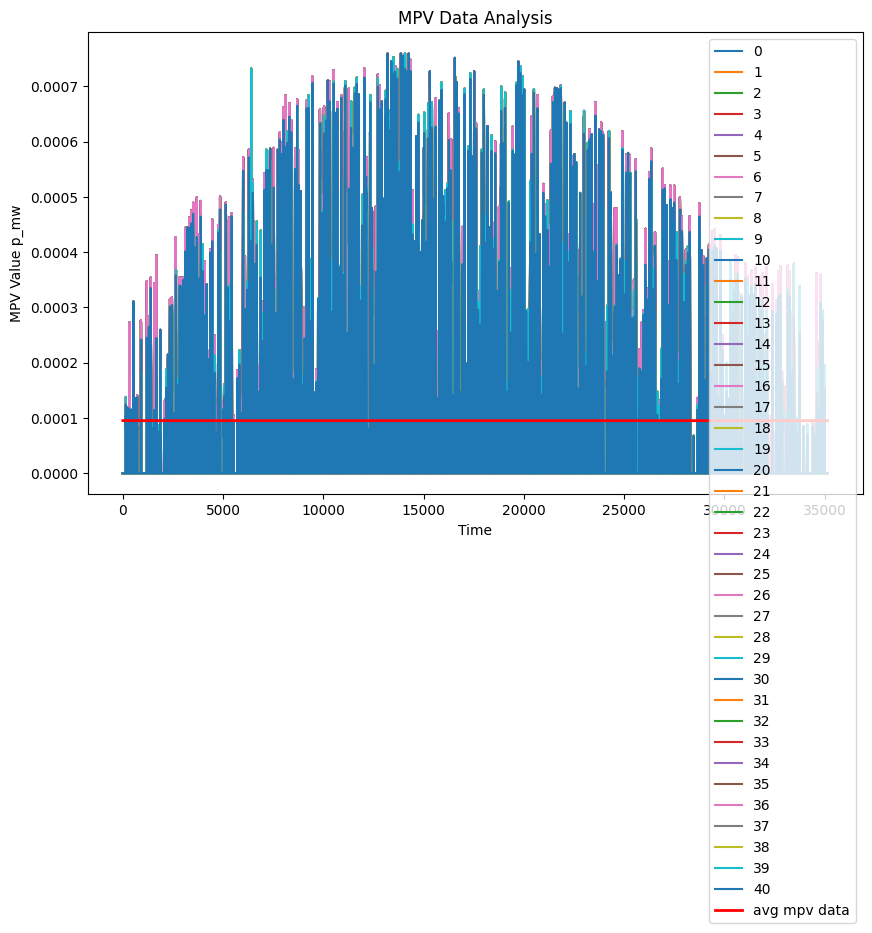

------------Analysis of Reactive Power Boundaries-----------
Rated power (s_max):               0.12 MVA
Power Factor (s_max/p_max):        1.00 %
Maximum Active Power of PV:        0.07 MW
Maximum Active Power of Load:      0.02 MW
PV Load Power Ratio (PV Max / Load Max):3.30 MW
---------------------- Load MPV Data -----------------------
max_avg_mpv_data:                  0.000760 MW
Index      Max Value      Avg Value      Std Value
------------------------------------------------------------
0          0.000760       0.000097       0.000166
1          0.000760       0.000092       0.000159
2          0.000760       0.000097       0.000166
3          0.000760       0.000097       0.000166
4          0.000760       0.000092       0.000159
5          0.000760       0.000092       0.000159
6          0.000760       0.000097       0.000166
7          0.000760       0.000097       0.000166
8          0.000760       0.000097       0.000166
9          0.000760       0.000092       0.000159

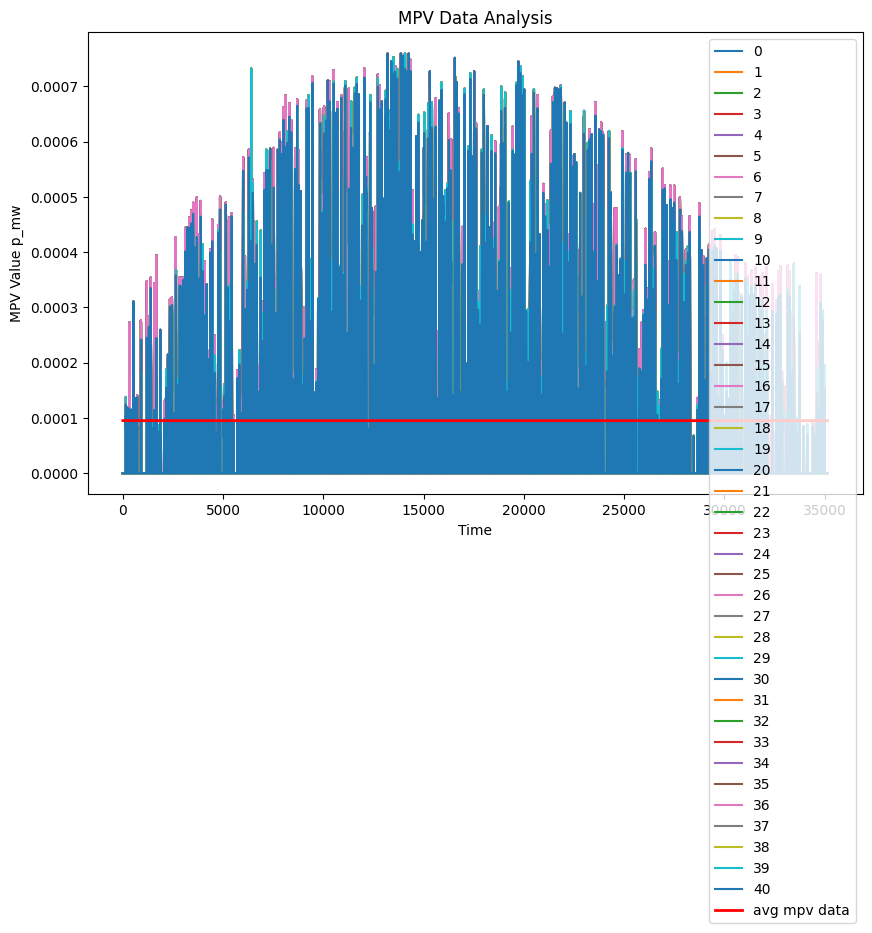

INFO:root:Running standard simulation
INFO:pandapower.control.util.auxiliary:Creating controller 2 of type <class 'helper.pv_controller.PVController'> 


-------------------  Penetration PV\MPV  -------------------
Total Apparent Power Load (S) in Simulation:                1022.48 MVA
Total Active Power Load (P) in Simulation:                  939.06 MW
Total Reactive Power Load (Q) in Simulation:                404.52 MVar
Total Active Power Generation from PV (P) in Simulation:    1896.92 MW
Total Active Power Generation from MPV (P) in Simulation:   137.05 MW
PV Penetration Rate (PR):                                   2.02
PV Penetration Rate (PR2):                                  1.86
MPV Penetration Rate (PR):                                  0.15
MPV Penetration Rate (PR2):                                 0.13
Penetration Info: successfully                              
saved in                                                    /hkfs/home/haicore/iai/ii6824/Documents/PIDE/output/local/35130_steps_1-LV-rural1--0-sw_vde_base_voltage_reactive_power_ctrl_rbc_pvbes_distributed_sc_ctrl_mpv_True_con_100/sim_info_data.txt

----------Pa

INFO:pandapower.control.util.auxiliary:Creating controller 3 of type <class 'helper.pv_controller.PVController'> 
INFO:pandapower.control.util.auxiliary:Creating controller 4 of type <class 'helper.pv_controller.PVController'> 
INFO:pandapower.control.util.auxiliary:Creating controller 5 of type <class 'helper.pv_controller.PVController'> 
INFO:pandapower.control.util.auxiliary:Creating controller 6 of type <class 'helper.pv_controller.PVController'> 
INFO:pandapower.control.util.auxiliary:Creating controller 7 of type <class 'helper.pv_controller.PVController'> 
INFO:pandapower.control.util.auxiliary:Creating controller 8 of type <class 'helper.pv_controller.PVController'> 
INFO:pandapower.control.util.auxiliary:Creating controller 9 of type <class 'helper.pv_controller.PVController'> 
INFO:pandapower.control.util.auxiliary:Creating controller 10 of type <class 'helper.pv_controller.PVController'> 
INFO:pandapower.control.util.auxiliary:Creating controller 11 of type <class 'helper.pv

True
---------------------- Load MPV Data -----------------------
max_avg_mpv_data:                  0.000760 MW
Index      Max Value      Avg Value      Std Value
------------------------------------------------------------
0          0.000760       0.000097       0.000166
1          0.000760       0.000092       0.000159
2          0.000760       0.000097       0.000166
3          0.000760       0.000097       0.000166
4          0.000760       0.000092       0.000159
5          0.000760       0.000092       0.000159
6          0.000760       0.000097       0.000166
7          0.000760       0.000097       0.000166
8          0.000760       0.000097       0.000166
9          0.000760       0.000092       0.000159
10         0.000760       0.000097       0.000166
11         0.000760       0.000097       0.000166
12         0.000760       0.000092       0.000159
13         0.000760       0.000092       0.000159
14         0.000760       0.000097       0.000166
15         0.000760      

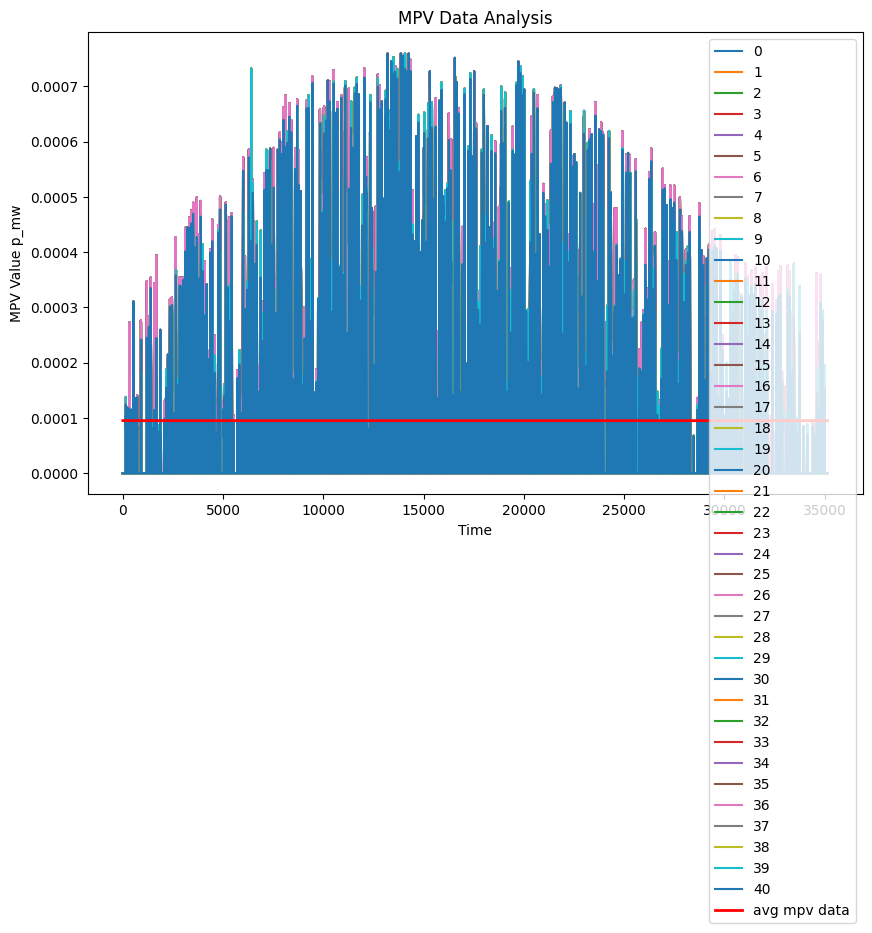

INFO:pandapower.control.util.auxiliary:Creating controller 15 of type <class 'helper.pv_controller.PVController'> 
INFO:pandapower.control.util.auxiliary:Creating controller 16 of type <class 'helper.pv_controller.PVController'> 
INFO:pandapower.control.util.auxiliary:Creating controller 17 of type <class 'helper.pv_controller.PVController'> 
INFO:pandapower.control.util.auxiliary:Creating controller 18 of type <class 'helper.pv_controller.PVController'> 
INFO:pandapower.control.util.auxiliary:Creating controller 19 of type <class 'helper.pv_controller.PVController'> 
INFO:pandapower.control.util.auxiliary:Creating controller 20 of type <class 'helper.pv_controller.PVController'> 
INFO:pandapower.control.util.auxiliary:Creating controller 21 of type <class 'helper.pv_controller.PVController'> 
INFO:pandapower.control.util.auxiliary:Creating controller 22 of type <class 'helper.pv_controller.PVController'> 
INFO:pandapower.control.util.auxiliary:Creating controller 23 of type <class 'he

mpvid: 0, mpv_idx: 13
mpvid: 1, mpv_idx: 14
mpvid: 2, mpv_idx: 15
mpvid: 3, mpv_idx: 16
mpvid: 4, mpv_idx: 17
mpvid: 5, mpv_idx: 18
mpvid: 6, mpv_idx: 19
mpvid: 7, mpv_idx: 20
mpvid: 8, mpv_idx: 21
mpvid: 9, mpv_idx: 22
mpvid: 10, mpv_idx: 23
mpvid: 11, mpv_idx: 24
mpvid: 12, mpv_idx: 25
mpvid: 13, mpv_idx: 26
mpvid: 14, mpv_idx: 27
mpvid: 15, mpv_idx: 28


INFO:pandapower.control.util.auxiliary:Creating controller 30 of type <class 'helper.pv_controller.PVController'> 
INFO:pandapower.control.util.auxiliary:Creating controller 31 of type <class 'helper.pv_controller.PVController'> 
INFO:pandapower.control.util.auxiliary:Creating controller 32 of type <class 'helper.pv_controller.PVController'> 
INFO:pandapower.control.util.auxiliary:Creating controller 33 of type <class 'helper.pv_controller.PVController'> 
INFO:pandapower.control.util.auxiliary:Creating controller 34 of type <class 'helper.pv_controller.PVController'> 
INFO:pandapower.control.util.auxiliary:Creating controller 35 of type <class 'helper.pv_controller.PVController'> 
INFO:pandapower.control.util.auxiliary:Creating controller 36 of type <class 'helper.pv_controller.PVController'> 
INFO:pandapower.control.util.auxiliary:Creating controller 37 of type <class 'helper.pv_controller.PVController'> 
INFO:pandapower.control.util.auxiliary:Creating controller 38 of type <class 'he

mpvid: 16, mpv_idx: 29
mpvid: 17, mpv_idx: 30
mpvid: 18, mpv_idx: 31
mpvid: 19, mpv_idx: 32
mpvid: 20, mpv_idx: 33
mpvid: 21, mpv_idx: 34
mpvid: 22, mpv_idx: 35
mpvid: 23, mpv_idx: 36
mpvid: 24, mpv_idx: 37
mpvid: 25, mpv_idx: 38
mpvid: 26, mpv_idx: 39
mpvid: 27, mpv_idx: 40


INFO:pandapower.control.util.auxiliary:Creating controller 46 of type <class 'helper.storage_controller.StorageController'> 
INFO:pandapower.control.util.auxiliary:Creating controller 47 of type <class 'helper.storage_controller.StorageController'> 
  0%|          | 0/35130 [00:00<?, ?it/s]INFO:pandapower.control.util.diagnostic:Same type and same matching parameters controllers ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42'] could affect convergence.
INFO:pandapower.control.util.diagnostic:Same type and same matching parameters controllers ['43', '44', '45', '46', '47'] could affect convergence.
 24%|██▎       | 8327/35130 [23:42<1:15:20,  5.93it/s]

In [ ]:
%%time
# Create folder for simulation results
folder_name = "output/mcs_folder"
os.makedirs(folder_name, exist_ok=True)

raw_log_mcs_data = []

# Checking the flag_monte_carlo argument
if arguments.flag_monte_carlo:
    # Monte Carlo simulations
    print("------------------ Monte Carlo Simulation ------------------\n")
    for i in range(arguments.num_monte_carlo_runs):
        arguments.seed_value += i
        print(f" Monte Carlo Run {i+1} of {arguments.num_monte_carlo_runs}")
        print(f" Current Seed Value: {arguments.seed_value}")
        pg_rbc_pp = PowerGridRuleBasedControlPP(arguments)
        logging.info("Running Monte Carlo simulation")
        try:
            pg_rbc_pp.run_main()
        except Exception as e:
            logging.error(f"Error during simulation: {e}")
            continue
        # Save simulation data
        raw_log_mcs_data.append(
            {"simulation": pg_rbc_pp.output, "arguments": arguments}
        )
        file_path = os.path.join(
            folder_name, f"{pg_rbc_pp.extended_path}_monte_carlo_sim_{i+1}.pkl"
        )
        with open(file_path, "wb") as f:
            pickle.dump(raw_log_mcs_data[-1], f)
        print(f"Saved Monte Carlo run {i+1} to: {file_path}")
    # Print completion message for Monte Carlo Simulation
    print("------------------ Monte Carlo Simulation Completed ------------------")
else:
    # Standard simulation
    pg_rbc_pp = PowerGridRuleBasedControlPP(arguments)
    logging.info("Running standard simulation")
    pg_rbc_pp.run_main()
    print("------------------ Standard Simulation Completed ------------------")
pg_rbc_pp.raw_log_mcs_data = raw_log_mcs_data

### Step 6: Evaluation, Analysis, and Visualization

In this step, we evaluate simulation results, analyze system performance, and visualize data for PowerGrid control simulations:
- **PowerGrid Evaluator:** Assess KPIs and control strategy effectiveness (if `timeseries_ctrl` is not "test_mode").
- **TestDERMode:** Validate DERs and control mechanisms (if `timeseries_ctrl` is "test_mode").
- **Data Analysis:** Perform statistical analysis and create visualizations.
- **Final Outputs:** Summarize findings in reports and store them in the `pg_rbc_pp_pge` dictionary for further reference.

In [ ]:
"""Evaluation and visualization."""

if arguments.timeseries_ctrl != "test_mode":
    logging.info("Running PowerGridEvaluator")
    pg_rbc_pp_pge = PowerGridEvaluator(pg_rbc_pp)
else:
    logging.info("Test mode active, skipping evaluation")
    pg_rbc_pp_pge = None

---
### Step 7: Example Parameter Values (Commented for Papermill Iteration)

- The following lines represent sample parameter values for Papermill iteration from the Bash script.
    - The following lines represent sample parameter values.
    - `ID= 0`
    - `MPV_CONCENTRATION_RATE_PERCENT= 25.00`
    - `MPV_INVERTER_APPARENT_POWER_WATT= 1000`
    - `MPV_SOLAR_CELL_CAPACITY_WATT= 2000`

- They are commented out for the Papermill iteration process initiated from the Bash script (Bash-Script: [02_run_powergrid_visualization.sh](/hkfs/home/haicore/iai/ii6824/powergrid-vde-ieee-control/02_run_powergrid_visualization.sh) ). These samples serve to illustrate the combination of parameters for clarity and do not impact the actual simulations.

After `print_kpi_and_mpv_parameters`, the script proceeds to execute the function that displays the KPI and MPV parameter settings. This action provides a detailed and organized overview of key parameters, facilitating validation and troubleshooting processes.

In [ ]:
# Execute the function to display the KPI and MPV parameter settings
# This action provides a detailed and organized overview of key parameters, aiding in validation and troubleshooting processes.
print_kpi_and_mpv_parameters(
    eval_instance=pg_rbc_pp_pge, eval_arguments=arguments, eval_seq_id=counter_seq_id
)

### Step 8: Compare Parameters with DataFrame
This code snippet defines a function `compare_parameters` to compare DataFrame values with specified parameters. If the values match, it returns "Match," otherwise, it returns "No Match." The comparison is performed on the DataFrame's first row.

In [ ]:
import pandas as pd


# Define a function to compare DataFrame values with passed parameters
def compare_parameters(df, concentration, inverter_power, solar_capacity):
    return (
        "Successful Cross-Check"
        if (
            df.iloc[0]["MPV_CONCENTRATION_RATE_PERCENT"] == concentration
            and df.iloc[0]["MPV_INVERTER_APPARENT_POWER_WATT"] == inverter_power
            and df.iloc[0]["MPV_SOLAR_CELL_CAPACITY_WATT"] == solar_capacity
        )
        else "Cross-Check Failed"
    )


# Create a DataFrame with example values (replace with actual values)
data_frame = pd.DataFrame(
    [
        {
            "ID": counter_seq_id,
            "MPV_CONCENTRATION_RATE_PERCENT": arguments.mpv_concentration_rate_percent,
            "MPV_INVERTER_APPARENT_POWER_WATT": arguments.mpv_inverter_apparent_power_watt,
            "MPV_SOLAR_CELL_CAPACITY_WATT": arguments.mpv_solar_cell_capacity_watt,
            "total_simulation_time": arguments.episode_limit,
            "transformer_loading_avg": pg_rbc_pp_pge.kpi_key["transformer_loading_avg"],
            "transformer_num_violations_dam": pg_rbc_pp_pge.kpi_key[
                "transformer_num_violations_dam"
            ],
            "lines_num_violations_dam_sum": pg_rbc_pp_pge.kpi_key[
                "lines_num_violations_dam_sum"
            ],
            "vm_lv_mean_avg": pg_rbc_pp_pge.kpi_key["vm_lv_mean_avg"],
            "kpi_key": pg_rbc_pp_pge.kpi_key,
        }
    ]
)

# Compare the DataFrame values with the Papermill parameters
comparison_result = compare_parameters(
    df=data_frame,
    concentration=MPV_CONCENTRATION_RATE_PERCENT,
    inverter_power=MPV_INVERTER_APPARENT_POWER_WATT,
    solar_capacity=MPV_SOLAR_CELL_CAPACITY_WATT,
)
print(f"{'Comparison Result:':<40}{comparison_result}")

In [ ]:
# Display the DataFrame
data_frame

### Step 9: Save Simulation Data as CSV
- This cell generates a unique CSV file name based on Papermill parameters.
- Parameters such as:
    - `sequence_id`(`ID`in Bash script)
    - `concentration_rate`(`CONCENTRATION_VALUES`in Bash script),
    - `inverter_power`(`INVERTER_POWER_VALUES`in Bash script),
    - `solar_capacity`(`SOLAR_CAPACITY_VALUES`in Bash script)

  are dynamically extracted from the Bash script and Papermill execution.
- Each simulation run results in an identifiable CSV file with the selected Papermill parameters, which can be found in the first cell of the Jupyter Notebook.
- This approach facilitates easy correlation of simulation data with the specific parameter values used for that run.

In [ ]:
# Generate a unique CSV file name incorporating Papermill parameters
# abs_csv_path = '/hkfs/home/haicore/iai/ii6824/powergrid-vde-ieee-control/output/notebook'
csv_path = f"{OUTPUT_NB_DIR}/simulations_data_{counter_seq_id}_{arguments.mpv_concentration_rate_percent}_{arguments.mpv_inverter_apparent_power_watt}_{arguments.mpv_solar_cell_capacity_watt}.csv"
# Save the DataFrame as a CSV file
data_frame.to_csv(csv_path, index=False)
# Print the path of the saved CSV file
print(f"{'CSV saved at:':<20}{csv_path}")

In [ ]:
print("Jupyter Notebook completed.")

### 5. Conclusion  <a id="5-conclusion"></a>

---
**Notebook Completed:** Congratulations! You have successfully completed this Jupyter Notebook. You have explored various simulations, conducted analyses, and generated valuable insights from the PowerGrid control system. Feel free to save and export your work as needed.

---


We appreciate your interest and hope the insights gained will be beneficial to your work or research.

Thank you for using this notebook. Have a great day!

---